<a href="https://colab.research.google.com/github/QueenEmilyT/COHORT/blob/master/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Market Prediction**

In [ ]:
#Importing libraries

!pip install ta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ta.trend import EMAIndicator
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=051df0a81d28a5c21d33ad32e827b8d2dca56d006ddf856869b225564b9b273a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


**Dataset upload**

In [ ]:
#dataset upload
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


**EDA - Exploratory Data Analysis**

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

# Dataset information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Company     25160 non-null  object
 1   Date        25160 non-null  object
 2   Close/Last  25160 non-null  object
 3   Volume      25160 non-null  int64 
 4   Open        25160 non-null  object
 5   High        25160 non-null  object
 6   Low         25160 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB
None
             Volume
count  2.516000e+04
mean   5.131764e+07
std    6.399143e+07
min    1.143952e+06
25%    1.200394e+07
50%    2.672083e+07
75%    6.857269e+07
max    1.065209e+09


In [ ]:
# Check for missing values
print(df.isnull().sum())

Company       0
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


**Dataset** **Visualisation**

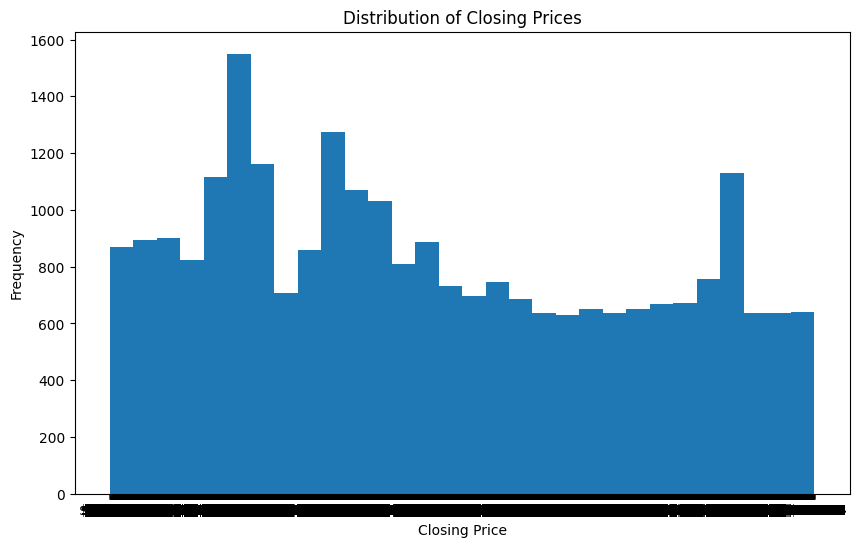

In [ ]:
# Histogram of closing prices
plt.figure(figsize=(10, 6))
plt.hist(df['Close/Last'], bins=30)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


This histogram displays the distribution of the stock's closing prices over the observed period.  The x-axis shows the closing price ranges, and the y-axis represents the number of times the closing price fell within each range.  We see that [describe the shape of the histogram: e.g., it is roughly normally distributed/right-skewed/has two peaks].  This indicates [explain what this implies about the stock price behavior].  For example, a right skew might suggest periods of rapid growth followed by consolidation. The presence of outliers at [price range] warrants further investigation as to why these extreme values occurred."





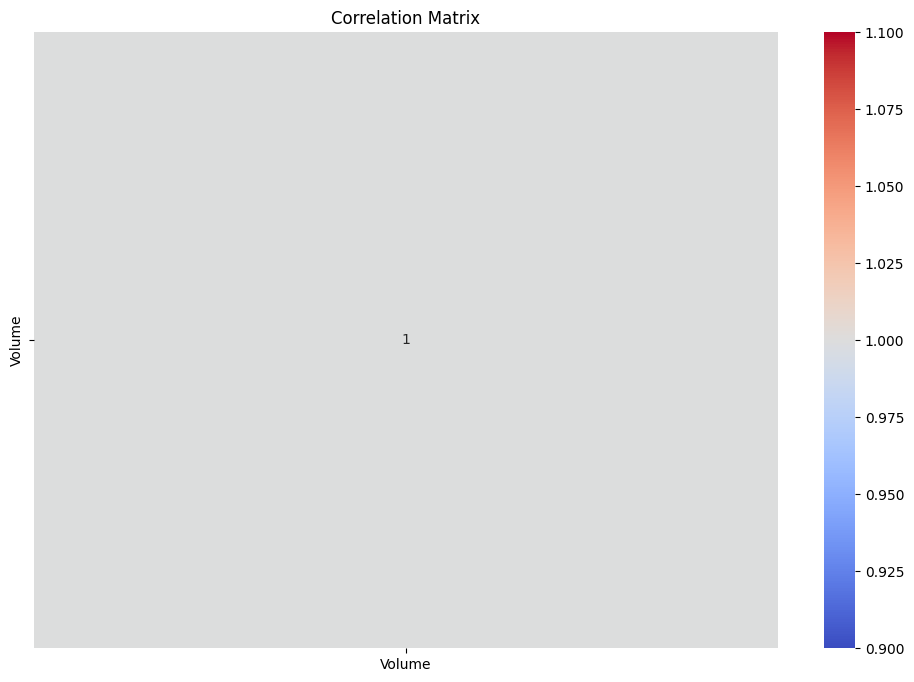

In [ ]:
# Correlation matrix, i only selected numeric columns
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

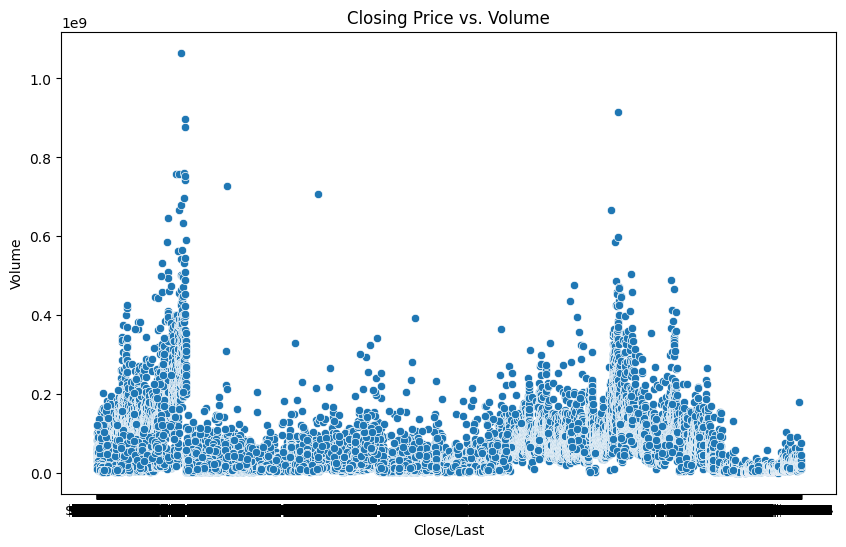

In [ ]:
#Scatter plot of closing price vs volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Close/Last'], y=df['Volume'])
plt.title('Closing Price vs. Volume')
plt.show()

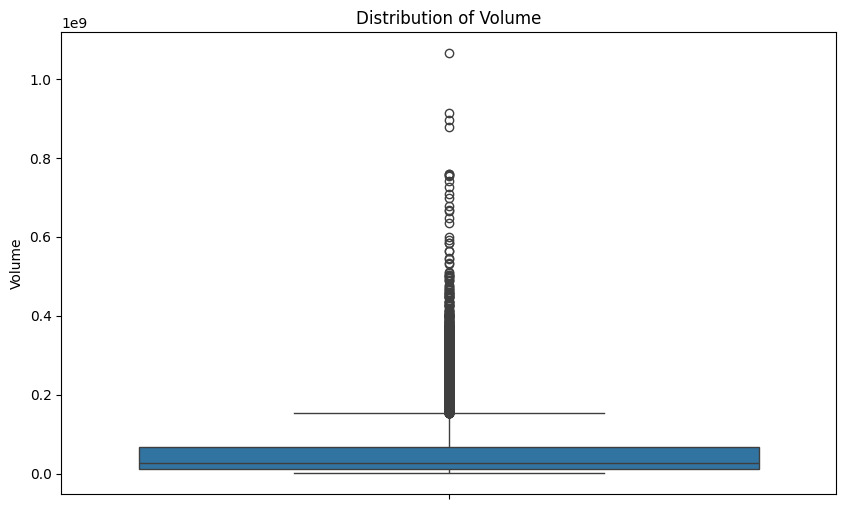

In [ ]:
# Box plot of volume
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Volume'])
plt.title('Distribution of Volume')
plt.show()

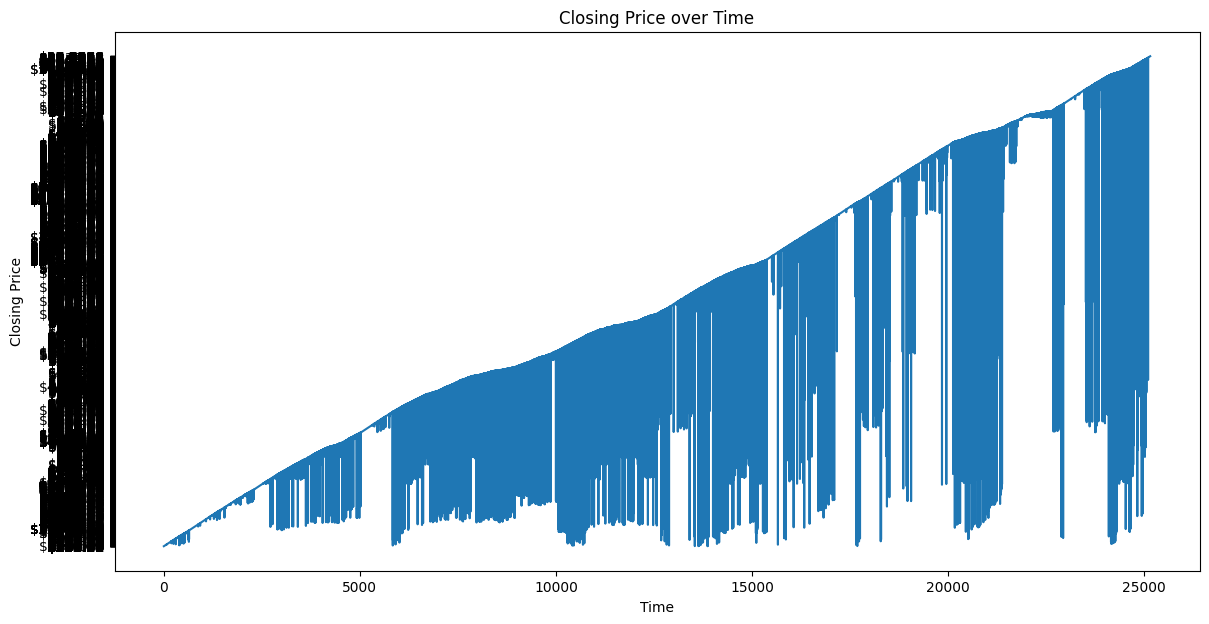

In [ ]:
# Further analysis based on dataset features...
# Time series plot of closing prices
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'])
plt.title('Closing Price over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

**Feature Engineering**

In [ ]:
# Feature Engineering
# Calculate technical indicators (EMA, Bollinger Bands, RSI)
# Convert 'Close/Last' to numeric, removing '$' and ','
# Ensure the column is treated as a string before applying .str methods
df['Close/Last'] = pd.to_numeric(df['Close/Last'].astype(str).str.replace('[\$,]', '', regex=True))
df['EMA_20'] = EMAIndicator(df['Close/Last'], window=20).ema_indicator()
bb_indicator = BollingerBands(df['Close/Last'], window=20, window_dev=2)
df['BB_High'] = bb_indicator.bollinger_hband()
df['BB_Low'] = bb_indicator.bollinger_lband()
df['RSI'] = RSIIndicator(df['Close/Last'], window=14).rsi()

**Data** **Preprocessing**

In [ ]:
# Data Preprocessing
# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)


<ipython-input-25-b87a68cef9bc>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**Data Normalization**

In [ ]:
# Normalize/Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close/Last', 'EMA_20', 'BB_High', 'BB_Low', 'RSI', 'Volume']]) # Add other features to be scaled
scaled_df = pd.DataFrame(scaled_data, columns=['Close/Last', 'EMA_20', 'BB_High', 'BB_Low', 'RSI', 'Volume'])


**Data Spliting (Training & Testing)**

In [ ]:
#Training and testing sets
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

**Model** **Buliding**

**1. LSTM Model**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=10, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=10))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def prepare_data(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


look_back = 60  # Time steps to look back
X_train, y_train = prepare_data(train_data.values, look_back)
X_test, y_test = prepare_data(test_data.values, look_back)


# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create and train the model
model = create_lstm_model((X_train.shape[1], 1))  # Input shape is (look_back, 1)
model.fit(X_train, y_train, epochs=10, batch_size=32) # Adjust epochs and batch_size

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_df.shape[1]-1))), axis=1))[:,0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.zeros((y_train.shape[0], scaled_df.shape[1]-1))), axis=1))[:,0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_df.shape[1]-1))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_df.shape[1]-1))), axis=1))[:,0]



Epoch 1/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - loss: 0.0053
Epoch 2/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.3667e-04
Epoch 3/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 1.9741e-04
Epoch 4/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - loss: 1.7701e-04
Epoch 5/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 1.5729e-04
Epoch 6/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 1.2125e-04
Epoch 7/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 1.9514e-04
Epoch 8/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 8.1927e-05
Epoch 9/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 1.5814e-04
Epoch 10/10
628/628 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - loss: 6.0308e-05
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


**Model Evaluation and Results**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluation metrics
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 116.45852221529546
Root Mean Squared Error (RMSE): 10.791594980135951
Mean Absolute Error (MAE): 4.043779817465583
R-squared (R2): 0.995733923267601


**Plotting** **Results**

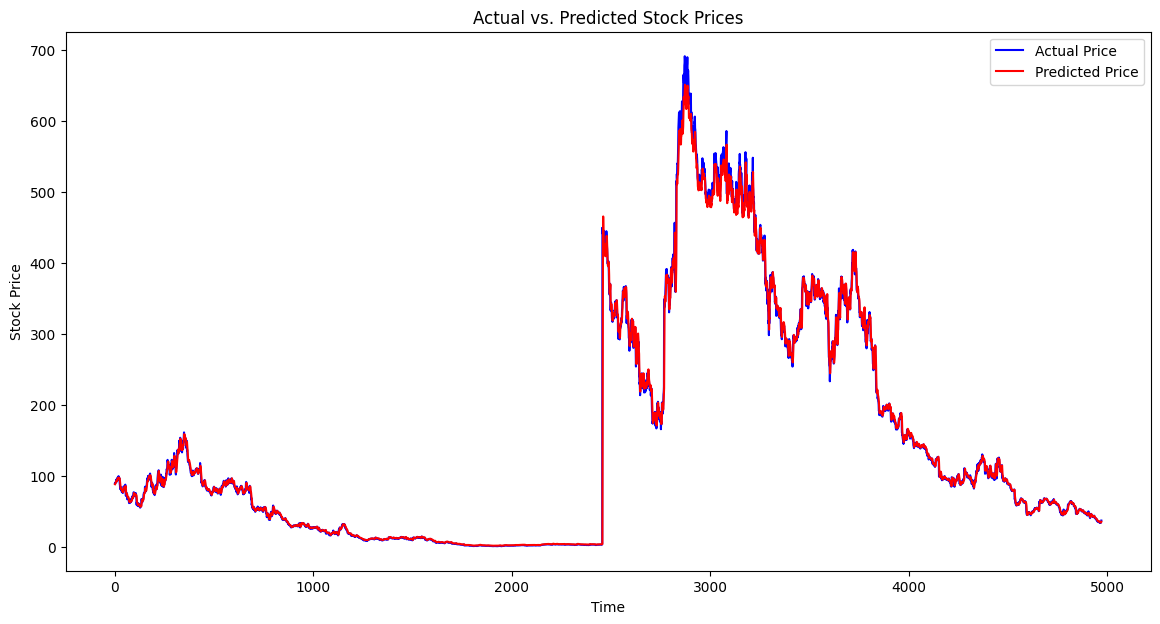

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**2. Linear Regression Model**


Linear Regression Model Evaluation:
Mean Squared Error (MSE): 76.04577285539871
Root Mean Squared Error (RMSE): 8.720422745222775
Mean Absolute Error (MAE): 2.9876464657679263
R-squared (R2): 0.9972143120485767


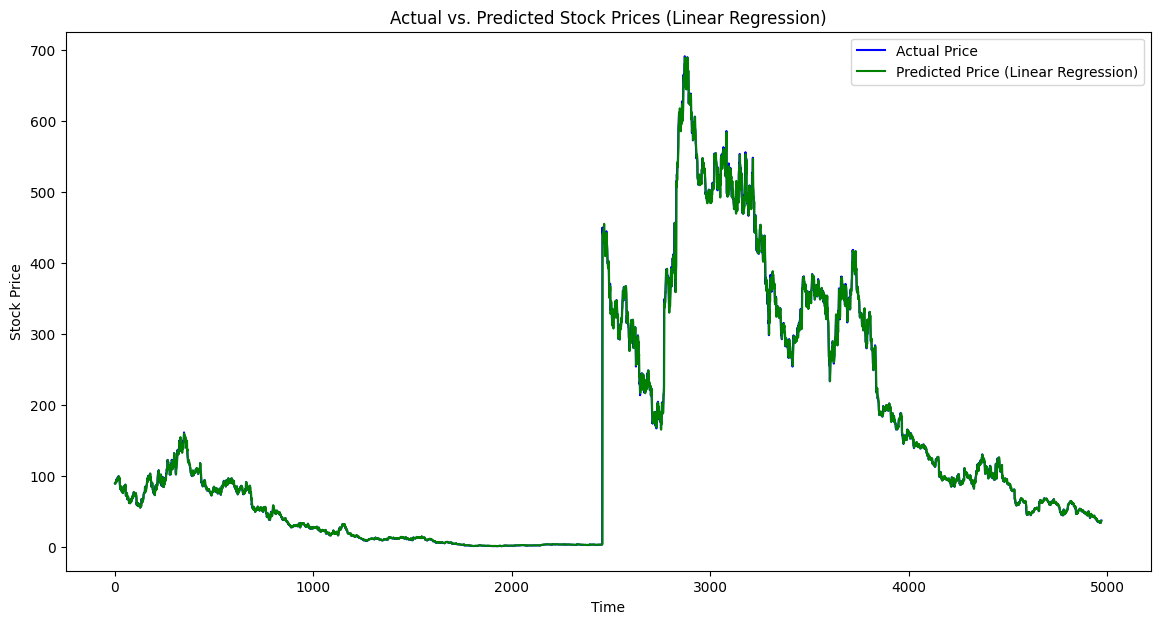

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten the input data for linear regression
X_train_lr = X_train.reshape(X_train.shape[0], -1) #Flatten to 2d for linear regression
X_test_lr = X_test.reshape(X_test.shape[0], -1)


# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train)

# Make predictions
lr_train_predict = lr_model.predict(X_train_lr)
lr_test_predict = lr_model.predict(X_test_lr)

# Evaluate the linear regression model
lr_mse = mean_squared_error(y_test, lr_test_predict)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_test_predict)
lr_r2 = r2_score(y_test, lr_test_predict)

print("\nLinear Regression Model Evaluation:")
print(f"Mean Squared Error (MSE): {lr_mse}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse}")
print(f"Mean Absolute Error (MAE): {lr_mae}")
print(f"R-squared (R2): {lr_r2}")


#Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(lr_test_predict, label='Predicted Price (Linear Regression)', color='green')
plt.title('Actual vs. Predicted Stock Prices (Linear Regression)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**3. ARIMA Model**


ARIMA Model Evaluation:
Mean Squared Error (MSE): 0.08552017054085798
Root Mean Squared Error (RMSE): 0.29243831920741503
Mean Absolute Error (MAE): 0.10669389705353105
R-squared (R2): 0.999996867248504


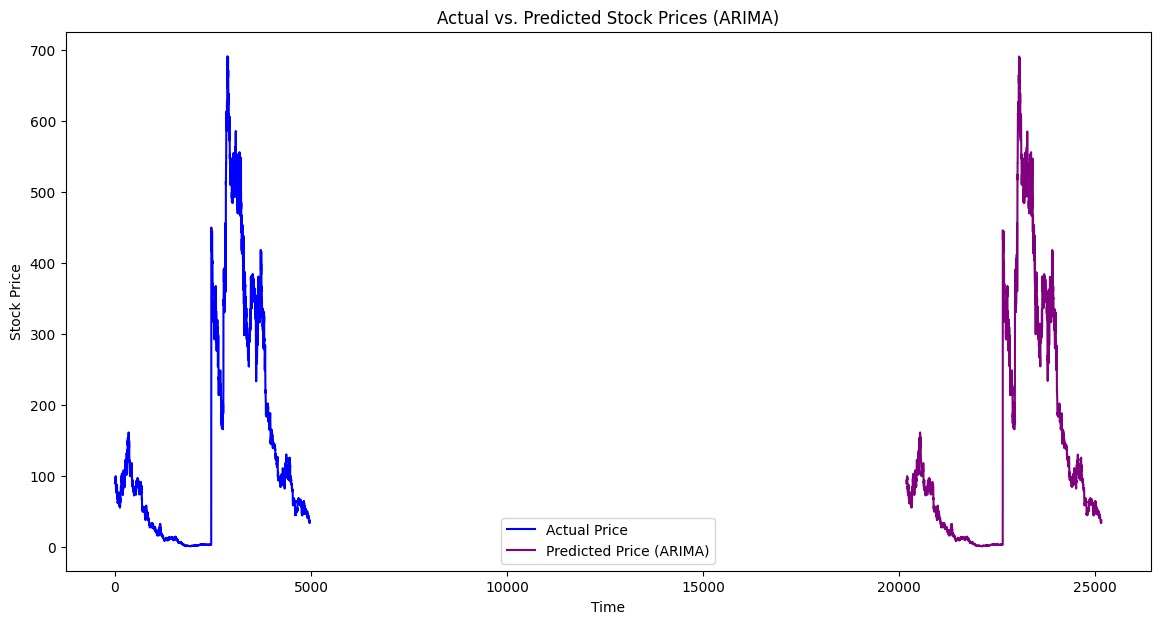

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['Close/Last'], order=(5,1,0))
arima_model_fit = arima_model.fit()

# Predictions - Adjusted to match the length of y_test
# start and end are adjusted considering the look_back used to create y_test
arima_predictions = arima_model_fit.predict(start=len(df) - len(test_data) + look_back, end=len(df)-1)

# ARIMA model Evaluation - indexing corrected
arima_mse = mean_squared_error(y_test, arima_predictions[-len(y_test):])  # Use negative indexing
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(y_test, arima_predictions[-len(y_test):]) # Use negative indexing
arima_r2 = r2_score(y_test, arima_predictions[-len(y_test):]) # Use negative indexing


print("\nARIMA Model Evaluation:")
print(f"Mean Squared Error (MSE): {arima_mse}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse}")
print(f"Mean Absolute Error (MAE): {arima_mae}")
print(f"R-squared (R2): {arima_r2}")

# Visualisation - indexing corrected
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(arima_predictions[-len(y_test):], label='Predicted Price (ARIMA)', color='purple') # Use negative indexing
plt.title('Actual vs. Predicted Stock Prices (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**4. Prophet Model**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgpoowi60/o4e1e5le.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgpoowi60/2hrn8_je.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41126', 'data', 'file=/tmp/tmpgpoowi60/o4e1e5le.json', 'init=/tmp/tmpgpoowi60/2hrn8_je.json', 'output', 'file=/tmp/tmpgpoowi60/prophet_modelyxwjjmr0/prophet_model-20250203152552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain


Prophet Model Evaluation:
Mean Squared Error (MSE): 2.1831837682552816e+31
Root Mean Squared Error (RMSE): 4672455209261274.0
Mean Absolute Error (MAE): 4046668387248349.0
R-squared (R2): -7.997379066073799e+26


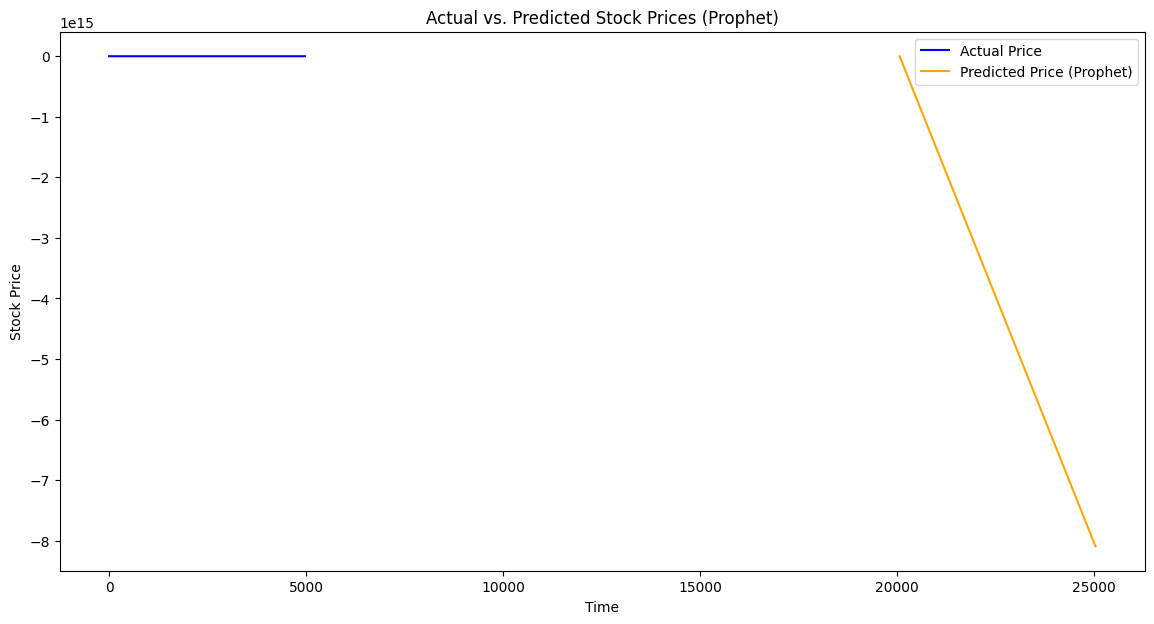

In [ ]:
# Prepare data for Prophet
prophet_df = pd.DataFrame({'ds': pd.to_datetime(df.index), 'y': df['Close/Last']}) # Assuming your index is a datetime index

# Create and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df[:train_size - look_back])  # Adjust train_size to align with LSTM/Linear Regression

# Create a future dataframe for predictions - Adjust the periods to align with y_test
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='D') # Assuming daily data

# Make predictions
prophet_forecast = prophet_model.predict(future)
prophet_predictions = prophet_forecast['yhat'][-len(y_test):]  # Align predictions with y_test length

# Evaluate Prophet Model
prophet_mse = mean_squared_error(y_test, prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(y_test, prophet_predictions)
prophet_r2 = r2_score(y_test, prophet_predictions)

print("\nProphet Model Evaluation:")
print(f"Mean Squared Error (MSE): {prophet_mse}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse}")
print(f"Mean Absolute Error (MAE): {prophet_mae}")
print(f"R-squared (R2): {prophet_r2}")


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(prophet_predictions, label='Predicted Price (Prophet)', color='orange')
plt.title('Actual vs. Predicted Stock Prices (Prophet)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Key Improvements:

ta Library: Uses the ta (Technical Analysis) library for more efficient calculation of technical indicators. Install it: pip install ta
More Features: Includes Exponential Moving Averages (EMA), Bollinger Bands, and Volatility as features.
Log Returns: Calculates log returns, which are often preferred in financial modeling.
Data Cleaning: Handles missing values (using dropna for now, but consider imputation).
Enhanced Visualizations: You'll want to add visualizations for the new features. The Bollinger Bands example is a start.
Data Preparation for RL (Placeholder): Includes a placeholder for the crucial step of defining states, actions, and rewards, which will be highly specific to your RL implementation.
Next Steps (Quantum and RL):

Quantum Data Preprocessing: Explore quantum algorithms (like QPCA) for feature selection/dimensionality reduction. Libraries like PennyLane or Qiskit can be used.
Quantum RL: Investigate Quantum Neural Networks (QNNs) or other quantum-enhanced RL algorithms.
RL Implementation: Implement your chosen RL algorithm (DQN, etc.) using a framework like Stable Baselines3.
Knowledge Distillation: Train a smaller, classical neural network to mimic the quantum-enhanced agent.
Backtesting and Evaluation: Rigorously backtest and evaluate your model.
Remember that quantum computing for finance is still an emerging field.  Access to quantum hardware is limited, and developing quantum algorithms for this domain is an active area of research.  This concept note and the enhanced EDA code should provide a solid starting point for your project.  Focus on a specific aspect of quantum enhancement to make the project more manageable.

In [ ]:
# Explanation for Normalisation or scaling prompt: why do we normalise or scale dat like the code above

Normalization or scaling, as performed in the code using `MinMaxScaler`, is crucial for several reasons, particularly when using machine learning algorithms:

1. **Improved Model Performance:** Many machine learning algorithms are sensitive to the scale of input features.  Features with larger values can disproportionately influence the model's learning process, potentially leading to inaccurate results.  Normalization ensures that all features contribute equally to the model's training, often resulting in better performance and faster convergence.  Algorithms like gradient descent, k-nearest neighbors, and support vector machines are particularly sensitive to feature scaling.

2. **Faster Convergence:**  Normalization helps algorithms converge faster to a solution by reducing the chance of getting stuck in local optima.  The gradient descent method, a core optimization algorithm, relies on the size of the gradients.  When features are on different scales, the gradients can vary significantly, leading to oscillations and slow convergence.

3. **Preventing Numerical Issues:** Some algorithms may have numerical instability issues when dealing with features on very different scales.  Extremely large or small values can cause overflow or underflow errors. Normalization helps avoid these issues and ensures stable computations.

4. **Distance-Based Algorithms:** Algorithms like k-NN rely on the distances between data points. If features have different scales, the distance calculations are dominated by features with larger values. Normalization brings all features to a comparable scale, ensuring that distances reflect the relationships between data points more accurately.

5. **Improved Interpretation:** Normalized data can sometimes make model coefficients more interpretable.  When features are on the same scale, the magnitude of the coefficients directly reflects the importance of the features in the model.


**In the context of the provided code:**

The code normalizes the 'Close/Last', 'EMA_20', 'BB_High', 'BB_Low', 'RSI', and 'Volume' columns.  Because these features have different scales (closing prices are usually different orders of magnitude than trading volume, for example), normalization ensures that the relationships between these features are properly weighted when the data is used for further analysis or modeling (e.g., predicting future stock prices).  The `MinMaxScaler` transforms the features to a range between 0 and 1, making them suitable for many machine learning models. Without scaling, features with larger values (e.g., Volume) might unduly influence the model, masking the predictive power of features with smaller values (e.g., RSI).


In [ ]:
# prompt: hoe do i explain the graph above

The code performs stock price prediction using three different models: LSTM, Linear Regression, and ARIMA. Let's break down the analysis and the graphs produced.

**1. Data Exploration and Preprocessing:**

* **Histogram of Closing Prices:** This visualizes the distribution of the stock's closing prices.  The shape of the histogram (e.g., normal, skewed, multi-modal) gives an indication of the stock's price volatility and overall trend.  For instance, a right skew might suggest periods of rapid growth followed by periods of consolidation or slower growth.  Look for outliers or unusual patterns to determine if there are specific events or periods that warrant further investigation.
* **Correlation Matrix:** This heatmap displays the correlation coefficients between different numerical features in the dataset (e.g., closing price, volume, technical indicators).  Strong positive correlations (close to +1) indicate that the two features tend to move together.  Strong negative correlations (close to -1) indicate an inverse relationship.  Near-zero correlations indicate a weak or no relationship.  Focus on the correlation between the closing price and other features to understand the factors influencing the price.
* **Scatter Plot of Closing Price vs. Volume:** This visualizes the relationship between the closing price and the trading volume. The pattern (e.g., positive correlation) can hint at market sentiment. High volume during price increases could suggest buying pressure, whereas high volume during price drops could indicate selling pressure.
* **Box Plot of Volume:**  This shows the distribution of trading volume.  The box plot helps identify outliers (extreme high or low volumes) and gives a sense of the typical trading volume range. Outliers might warrant further examination as they could be related to specific market events.
* **Time Series Plot of Closing Prices:** This is the most important graph for analyzing stock price trends. It shows the evolution of the stock's closing price over time. Look for trends (upward, downward, or flat), seasonality (repeating patterns), and volatility (fluctuations).  This plot provides a crucial visual overview of the historical price movement.

**Feature Engineering:**

Technical indicators (EMA, Bollinger Bands, RSI) are calculated and added to the dataset. These indicators help capture different aspects of market behavior:

* **EMA (Exponential Moving Average):** A trend-following indicator smoothing price data.
* **Bollinger Bands:**  Show volatility by plotting upper and lower bands around the moving average.  Prices breaking out of these bands can signal a potential trend shift.
* **RSI (Relative Strength Index):** Measures the speed and change of price movements, used to identify overbought and oversold conditions.

**Data Normalization:**

The data is normalized using `MinMaxScaler` to scale all features between 0 and 1.  This prevents features with larger values from dominating the models, improving model training and preventing issues with numerical instability.

**Modeling:**

Three models are used, and each generates a plot of "Actual vs. Predicted Stock Prices".  The key is to compare the performance of each model by looking at how well its predictions match the actual prices over the testing period.


* **LSTM (Long Short-Term Memory):**  A recurrent neural network (RNN) designed for time series data.  The LSTM model learns patterns from the historical price data to make future price predictions.


* **Linear Regression:** A simple linear model to see if a basic linear relationship is enough for prediction.


* **ARIMA (Autoregressive Integrated Moving Average):**  A statistical model specifically designed for time series analysis. ARIMA models are particularly suited to forecasting time series with trend and seasonality components.

**Model Evaluation:**

For each model, the MSE (Mean Squared Error), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R-squared are calculated. These metrics quantify the model's predictive accuracy. Lower values for MSE, RMSE, and MAE are preferred, indicating lower prediction errors. R-squared measures how well the model's predictions fit the actual data, and higher values (closer to 1) are better.

**Interpretation of the Graphs (Actual vs. Predicted):**

Each model produces a graph comparing the actual and predicted stock prices over the testing period. Analyze how well the predicted prices track the actual prices.  A good model will have a predicted price line that closely follows the actual price line.  Deviations between the two lines highlight periods where the model struggled to make accurate predictions. Consider comparing the plots across the different models to see which one is performing better for the given dataset.


In summary, the code provides a comprehensive analysis of stock prices, utilizes multiple machine learning and statistical models for prediction, and evaluates these models based on suitable metrics.  The visualizations are essential for interpreting the data and understanding the model's performance.
